In [284]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Импортируем необходимые библиотеки машинного обучения
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Импортируем библиотеку nltk для анализа настроений позитивных и негативных отзывов
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Используем библиотеку geopy для восстановления пропущенных координат
from geopy.geocoders import Nominatim

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [285]:
random_seed = 42 # фиксируем random_seed, чтобы результаты эксперимента были вопроизводимы
!pip freeze > requirements.txt # фиксируем версию пакетов, чтобы результаты эксперимента были вопроизводимы

# Подготовка и загрузка данных

In [286]:
# Подгружаем данные из соревнования
data_dir = '/kaggle/input/sf-booking/'
data_train = pd.read_csv(data_dir + '/hotels_train.csv') # датасет для обучения
data_test = pd.read_csv(data_dir + '/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(data_dir + '/submission.csv') # самбмишн

In [287]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
data_train['sample'] = 1 # помечаем трейн
data_test['sample'] = 0 # помечаем тест
data_test['reviewer_score'] = 0 # заполняем нулями признак reviewer_score в тесте

data = pd.concat([data_test, data_train], axis=0, ignore_index=True)

# Исследование данных и работа с признаками

In [288]:
data.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


In [289]:
# Находим массив уникальных наименований отелей, у которых пропущены координаты
data[(data['lat'].isnull()) & (data['lng'].isnull())]['hotel_name'].unique()

array(['Hotel Atlanta', 'City Hotel Deutschmeister',
       'Holiday Inn Paris Montmartre',
       'Fleming s Selection Hotel Wien City', 'Hotel City Central',
       'Cordial Theaterhotel Wien', 'NH Collection Barcelona Podium',
       'Hotel Daniel Vienna', 'Maison Albar Hotel Paris Op ra Diamond',
       'Mercure Paris Gare Montparnasse',
       'Hotel Pension Baron am Schottentor',
       'Austria Trend Hotel Schloss Wilhelminenberg Wien',
       'Renaissance Barcelona Hotel',
       'Derag Livinghotel Kaiser Franz Joseph Vienna', 'Roomz Vienna',
       'Hotel Park Villa', 'Hotel Advance'], dtype=object)

In [290]:
# Находим массив уникальных адресов отелей, у которых пропущены координаты
data[(data['lat'].isnull()) & (data['lng'].isnull())]['hotel_address'].unique()

array(['W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
       'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
       '23 Rue Damr mont 18th arr 75018 Paris France',
       'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
       'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
       'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
       'Bail n 4 6 Eixample 08010 Barcelona Spain',
       'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
       '4 rue de la P pini re 8th arr 75008 Paris France',
       '20 Rue De La Ga t 14th arr 75014 Paris France',
       'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
       'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
       'Pau Clar s 122 Eixample 08009 Barcelona Spain',
       'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
       'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
       'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
       'Sep lveda 180 Eix

In [291]:
# Используя библиотеку geopy находим приблизительные координаты пропущенных отелей, пример:
geolocator = Nominatim(user_agent='User_geo')
location = geolocator.geocode('Josefstadt, 1080, Vienna Austria')

print(location.latitude, location.longitude)

48.2108519 16.347359861911986


In [292]:
# Из полученных значений формируем для удобства словарь
coor_dict = {
    'Fleming s Selection Hotel Wien City':[48.209095, 16.354568],
    'Hotel City Central':[48.213560, 16.379923],
    'Hotel Atlanta':[48.220310, 16.355880],
    'Maison Albar Hotel Paris Op ra Diamond':[48.875140, 2.323420],
    'Hotel Daniel Vienna':[48.188835, 16.383810],
    'Hotel Pension Baron am Schottentor':[48.216705, 16.359820],
    'Austria Trend Hotel Schloss Wilhelminenberg Wien':[48.219555, 16.285566],
    'NH Collection Barcelona Podium':[41.391430, 2.177890],
    'Derag Livinghotel Kaiser Franz Joseph Vienna':[48.245914, 16.341188],
    'City Hotel Deutschmeister':[48.220856, 16.366642],
    'Holiday Inn Paris Montmartre':[48.888860, 2.333190],
    'Hotel Park Villa':[48.233495, 16.345556],
    'Cordial Theaterhotel Wien':[48.209530, 16.351515],
    'Roomz Vienna':[48.22201, 16.39331],
    'Mercure Paris Gare Montparnasse':[48.839701, 2.323519],
    'Hotel Advance':[41.38322, 2.16295],
    'Renaissance Barcelona Hotel':[41.392430, 2.167500]
}

# Создаём функцию, которая будет подставлять пропущенные координаты
def get_coor(row):
    if pd.isnull(row.lat):
        row.lat = coor_dict[row.hotel_name][0]
        row.lng = coor_dict[row.hotel_name][1]
        return row
    else: 
        return row
    
# Подставляем координаты
data = data.apply(lambda row: get_coor(row), axis=1) 

In [293]:
# Из признака hotel_address создаём признак hotel_country
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1])

data = pd.get_dummies(data, columns=['hotel_country'], dtype=int) # кодируем новый признак

In [294]:
data['review_date'] = pd.to_datetime(data['review_date'])

# Из признака review_date создаём два признака review_year и review_month
data['review_year'] = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month

data = pd.get_dummies(data, columns=['review_year', 'review_month'], dtype=int) # кодируем новые признаки

In [295]:
data['reviewer_nationality'].value_counts(normalize=True)*100

reviewer_nationality
United Kingdom               47.552439
United States of America      6.871124
Australia                     4.204848
Ireland                       2.874909
United Arab Emirates          1.984535
                               ...    
Comoros                       0.000194
Anguilla                      0.000194
Tuvalu                        0.000194
Cape Verde                    0.000194
Palau                         0.000194
Name: proportion, Length: 227, dtype: float64

In [296]:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: 1 if x == ' United Kingdom ' else 0)

In [297]:
sent_analyzer = SentimentIntensityAnalyzer() # задаём инструмент для анализа настроений позитивных и негативных отзывов

data['ngreview_neg'] = data['negative_review'].apply(lambda x: (sent_analyzer.polarity_scores(x))['neg'])
data['ngreview_neu'] = data['negative_review'].apply(lambda x: (sent_analyzer.polarity_scores(x))['neu'])
data['ngreview_pos'] = data['negative_review'].apply(lambda x: (sent_analyzer.polarity_scores(x))['pos'])
data['ngreview_compound'] = data['negative_review'].apply(lambda x: (sent_analyzer.polarity_scores(x))['compound'])

data['psreview_neg'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
data['psreview_neu'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neu'])
data['psreview_pos'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
data['psreview_compound'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

In [298]:
# Работаем с признаком tags
data['tags'] = data['tags'].apply(lambda x: x.replace('[', ''))
data['tags'] = data['tags'].apply(lambda x: x.replace(']', ''))
data['tags'] = data['tags'].apply(lambda x: x.replace("' ", ''))
data['tags'] = data['tags'].apply(lambda x: x.replace(" '", ''))
data['tags'] = data['tags'].apply(lambda x: x.replace("'", ''))
data['tags'] = data['tags'].apply(lambda x: x.replace(", ", ','))

data['tags'] = data['tags'].apply(lambda x: x.split(','))
data_exploded = data.explode('tags')

data_exploded['tags'].value_counts(normalize=True)*100

tags
Leisure trip                                17.728058
Submitted from a mobile device              13.054445
Couple                                      10.705884
Stayed 1 night                               8.217163
Stayed 2 nights                              5.683504
                                              ...    
Duplex King Suite 3 Adults                   0.000042
Suite Free Executive Lounge Access           0.000042
Suite with Executive Lounge Access           0.000042
Family Room three bedrooms communicating     0.000042
Quadruple Room 2 Adults 2 Children           0.000042
Name: proportion, Length: 2428, dtype: float64

In [299]:
data['Leisure trip'] = data['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
data['Submitted from a mobile device'] = data['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)
data['Couple'] = data['tags'].apply(lambda x: 1 if 'Couple' in x else 0)
data['Stayed 1 night'] = data['tags'].apply(lambda x: 1 if 'Stayed 1 night' in x else 0)
data['Stayed 2 nights'] = data['tags'].apply(lambda x: 1 if 'Stayed 2 nights' in x else 0)

In [300]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0])

In [301]:
scaler = preprocessing.RobustScaler() # задаём инструмент для нормализации определённых признаков

norm_names = ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts','total_number_of_reviews', 
              'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'lat', 'lng']

norm_data = scaler.fit_transform(data[norm_names])

norm_data = pd.DataFrame(norm_data, columns=norm_names)

In [302]:
data = data.drop(norm_names, axis=1) # удаляем нормализованные признаки
# Удаляем все остальные использованные признаки
data = data.drop(['hotel_address', 'hotel_name', 'review_date', 'negative_review', 'positive_review', 'tags'], axis=1)

In [303]:
data = pd.concat([data, norm_data], axis=1) # конкатенируем датасет с нормализованными признаками

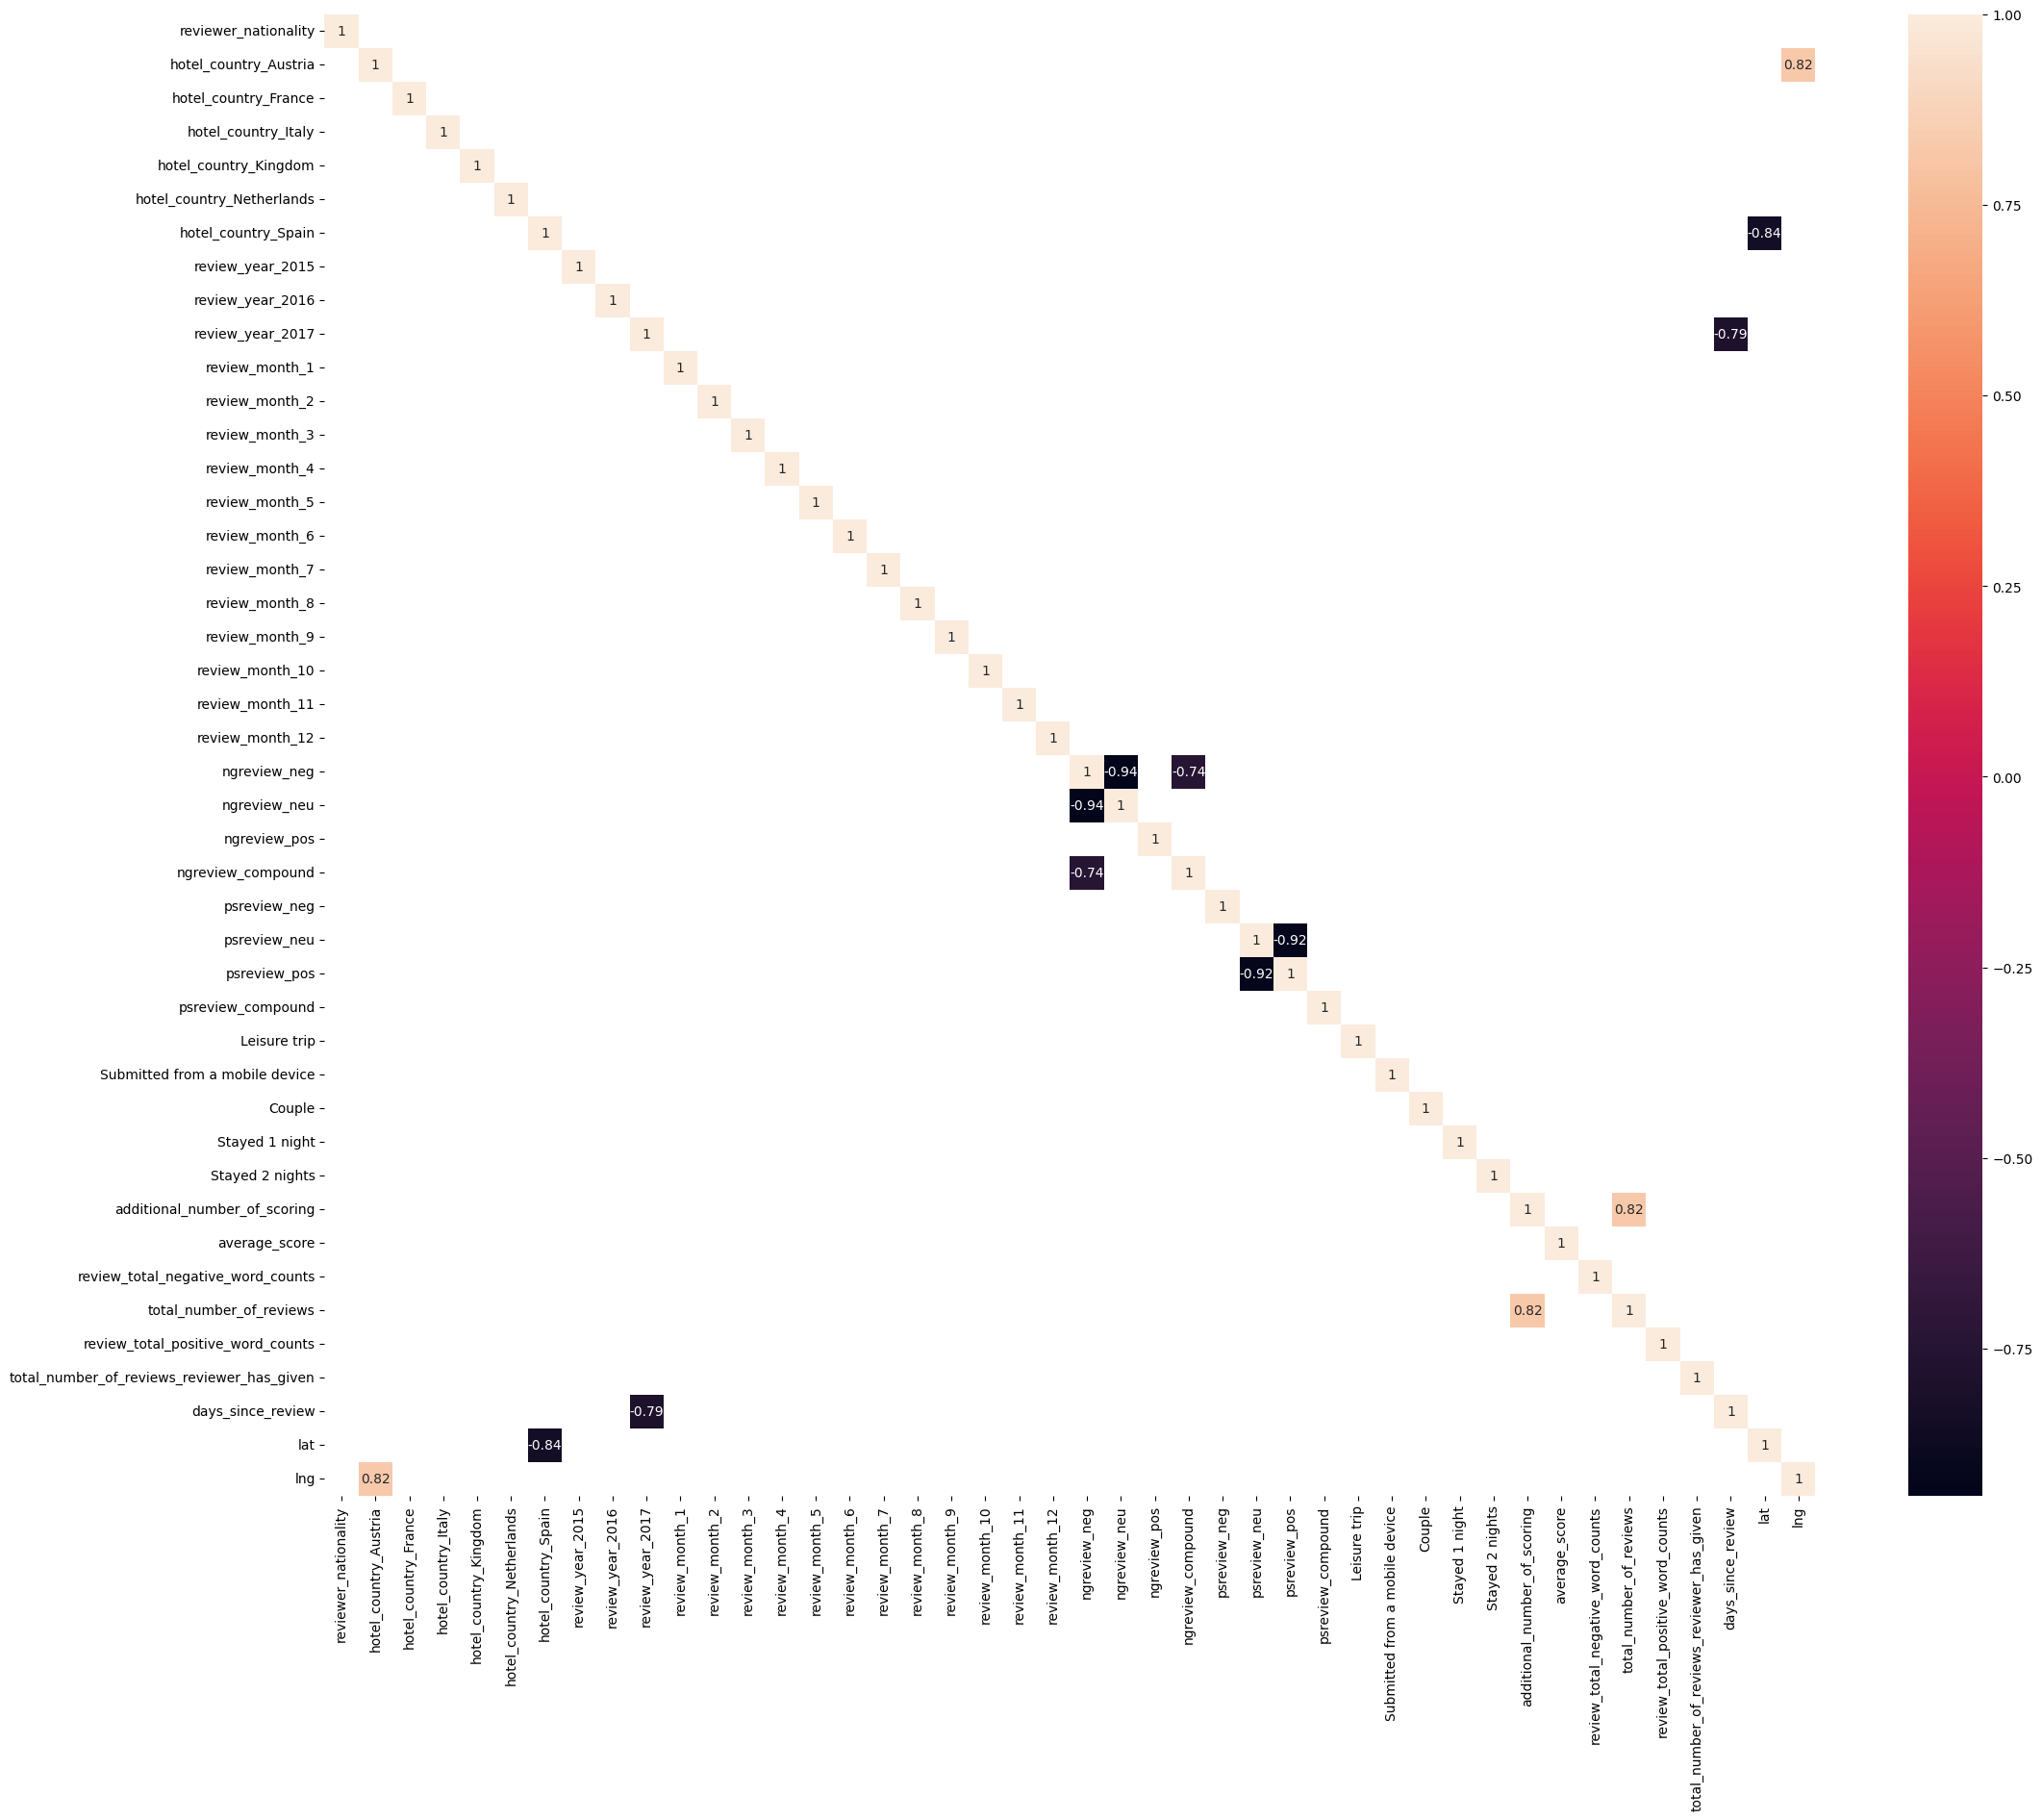

In [304]:
# Строим график корреляции признаков для оптимизации наших данных
plt.rcParams['figure.figsize'] = (25,20)
corr_data = data.drop(['sample', 'reviewer_score'], axis=1).corr()
corrdata_filtered = corr_data[(corr_data < -0.7) | (corr_data > 0.7)]
sns.heatmap(corrdata_filtered, annot=True);

По графику видно, что некоторые признаки довольно сильно скоррелированы, но в большинстве из этих случаев сильная связь выглядит случайной: например, признак одной страны сильно скоррелирован с широтой, а другой страны - с долготой; признак одного года скоррелирован с признаком количества дней между датой проверки и датой очистки; также, при проведении эксперимента выяснилось, что удаление этих признаков немного ухудшает результат метрики, поэтому эти признаки мы оставим. Признаки ngreview_neg и psreview_pos - удалять не будем тоже, хоть они и сильно коррелируют с некоторыми другими признаками, созданными нами в разделе анализа настроений отзывов, поскольку при проведении эксперимента также выяснилось, что удаление этих двух признаков незначительно ухудшает результат метрики.

# Построение и обучение модели, получение результатов

In [306]:
# Обратно разделяем датасет на трейн и тест
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # целевые значения
X = train_data.drop(['reviewer_score'], axis=1) 

In [307]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed) # разделяем данные для 
# обучения и теста

model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=random_seed) # создаём модель

model.fit(X_train, y_train) # обучаем модель на тестовом наборе данных

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [308]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они в среднем отличаются (метрика Mean 
# Absolute Percentage Error (MAPE) показывает среднее отклонение предсказанных значений от фактических)
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12543826268820407


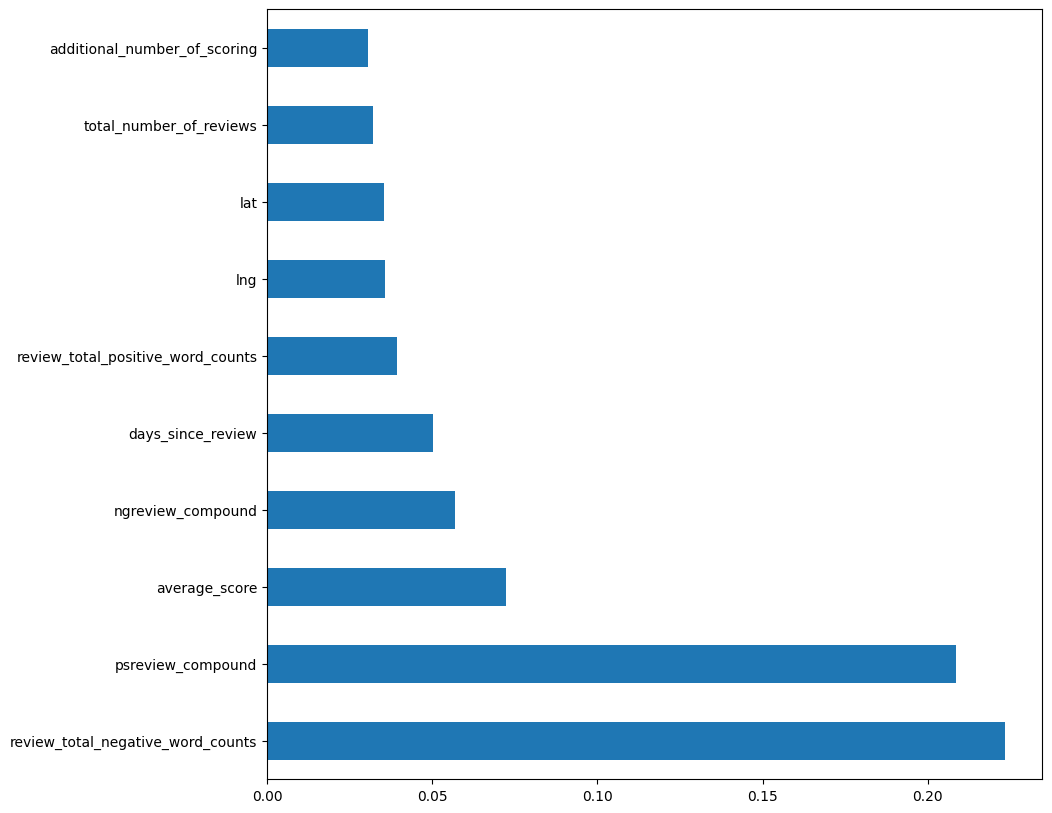

In [309]:
# Выводим самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh');

По графику видно, что самым важным признаком в нашем наборе данных является признак review_total_negative_word_counts, на втором месте, не слишком отставая от него - psreview_compound, а это обозначает, что мы неплохо поработали с признаками. Также это говорит о том, что позитивный отзыв намного важнее для предсказания рейтинга отеля, чем негативный, поскольку признак ngreview_compound в несколько раз менее важен, чем psreview_compound. Можно было бы удалить часть наименее важных признаков, но при проведении эксперимента выяснилось, что удаление таких признаков незначительно ухудшает результат метрики.

In [310]:
test_data = test_data.drop(['reviewer_score'], axis=1)

predict_submission = model.predict(test_data) # предсказываем сабмишн на тесте

sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished


# Финальный вывод

Нашей задачей было построить модель, которая предсказывает рейтинг отеля для выявления нечестных отелей, которые накручивают себе рейтинг. С поставленной задачей мы успешно справились. В процессе работы мы постарались использовать все полученные знания. Мы очистили и исследовали данные, сгенерировали признаки, отобрали и преобразовали наиболее важные для предсказания рейтинга отеля из них. Также в процессе работы были изучены и рассмотрены десятки идей по работе с признаками и, в конечном итоге, по улучшению результата метрики. Работа получилась сложной и трудоёмкой, но очень интересной, поскольку в её процессе были апробированы не только полученные знания, но и использовались рекомендации ментора Сергея Добдина, а также дополнительно были изучены десятки нюансов качественной подготовки данных к машинному обучению.